# 第32章: 多次元正規分布と共分散

## 📋 この章で学ぶこと

この章を終えると、以下ができるようになります：

- [ ] 多次元配列とベクトル演算を使いこなせる
- [ ] 多次元正規分布の式を理解できる
- [ ] 共分散行列の意味を説明できる
- [ ] 2次元正規分布を可視化できる
- [ ] 多次元データの最尤推定ができる

## 🎯 前提知識

この章を学ぶには以下の知識が必要です：

- ✅ Notebook 30（正規分布と確率の基礎）
- ✅ Notebook 31（最尤推定と生成モデルの基礎）
- ✅ 基本的な線形代数（ベクトル、行列の基礎）

⏱️ **推定学習時間**: 120-150分  
📊 **難易度**: ★★★☆☆（中級）  
🎓 **カテゴリ**: 基礎

---

## 🌟 はじめに

前章までは**1次元の正規分布**を扱ってきました。しかし、現実のデータは複数の変数を持つ**多次元データ**であることがほとんどです：

- 人のデータ: 身長、体重、年齢、...
- 画像データ: 各ピクセルの値（28×28=784次元など）
- テキストデータ: 単語の埋め込みベクトル（数百次元）

このような多次元データを扱うために、**多次元正規分布（Multivariate Normal Distribution）**を学びます。

### 🤔 なぜ多次元正規分布が重要なのか？

1. **VAE（変分オートエンコーダ）**: 潜在空間は多次元正規分布
2. **拡散モデル**: ノイズは多次元正規分布からサンプリング
3. **ガウス過程**: 無限次元の正規分布を使う
4. **主成分分析（PCA）**: 共分散行列の固有値分解

In [1]:
# ============================================================
# 環境設定
# 必要なライブラリをインポートし、グラフの表示設定を行います
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D
import warnings

# 警告を非表示
warnings.filterwarnings('ignore')

# グラフスタイルの設定
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# 日本語フォント設定
import matplotlib.font_manager as fm

def setup_japanese_font():
    """日本語フォントを設定する"""
    japanese_fonts = [
        'Hiragino Sans', 'Hiragino Maru Gothic Pro', 'AppleGothic',
        'Yu Gothic', 'MS Gothic',
        'Noto Sans CJK JP', 'IPAexGothic', 'TakaoPGothic',
    ]
    available_fonts = set(f.name for f in fm.fontManager.ttflist)
    for font in japanese_fonts:
        if font in available_fonts:
            plt.rcParams['font.family'] = font
            plt.rcParams['axes.unicode_minus'] = False
            return font
    return None

font_used = setup_japanese_font()
if font_used:
    print(f"日本語フォント: {font_used}")

# 再現性のための乱数シード
np.random.seed(42)

print("✅ ライブラリのインポート完了")

日本語フォント: Hiragino Sans
✅ ライブラリのインポート完了


---

## 1. ベクトルと行列の基礎（復習）

### 📊 ベクトルの表記

多次元データは**ベクトル**で表現します：

$$\mathbf{x} = \begin{pmatrix} x_1 \\ x_2 \\ \vdots \\ x_d \end{pmatrix}$$

ここで $d$ は次元数です。例えば、身長と体重の2次元データなら $d=2$ です。

### 📊 行列の表記

複数のデータ点をまとめたものは**行列**で表現します：

$$X = \begin{pmatrix} x_1^{(1)} & x_2^{(1)} & \cdots & x_d^{(1)} \\ x_1^{(2)} & x_2^{(2)} & \cdots & x_d^{(2)} \\ \vdots & \vdots & \ddots & \vdots \\ x_1^{(n)} & x_2^{(n)} & \cdots & x_d^{(n)} \end{pmatrix}$$

- $n$ 行: サンプル数
- $d$ 列: 特徴量の数（次元）

In [2]:
# ============================================================
# NumPyでのベクトルと行列の操作
# 基本的な演算を復習します
# ============================================================

print("="*60)
print("ベクトルと行列の基本操作")
print("="*60)

# ベクトルの作成
v = np.array([170, 65])  # 身長170cm, 体重65kg
print(f"\nベクトル v:")
print(f"  v = {v}")
print(f"  形状: {v.shape}")

# 行列の作成（5人分のデータ）
X = np.array([
    [170, 65],   # 人1
    [165, 55],   # 人2
    [180, 75],   # 人3
    [168, 60],   # 人4
    [175, 70],   # 人5
])
print(f"\n行列 X (5人×2特徴量):")
print(X)
print(f"  形状: {X.shape}  (n={X.shape[0]}サンプル, d={X.shape[1]}次元)")

# 列ごとの平均（各特徴量の平均）
mean_vector = np.mean(X, axis=0)
print(f"\n平均ベクトル μ = {mean_vector}")
print(f"  → 平均身長: {mean_vector[0]:.1f}cm, 平均体重: {mean_vector[1]:.1f}kg")

ベクトルと行列の基本操作

ベクトル v:
  v = [170  65]
  形状: (2,)

行列 X (5人×2特徴量):
[[170  65]
 [165  55]
 [180  75]
 [168  60]
 [175  70]]
  形状: (5, 2)  (n=5サンプル, d=2次元)

平均ベクトル μ = [171.6  65. ]
  → 平均身長: 171.6cm, 平均体重: 65.0kg


In [3]:
# ============================================================
# 重要な行列演算
# 多次元正規分布で使う演算を確認します
# ============================================================

print("="*60)
print("重要な行列演算")
print("="*60)

# 1. 転置
A = np.array([[1, 2], [3, 4], [5, 6]])
print(f"\n1. 転置 (Transpose)")
print(f"A = \n{A}")
print(f"A.T = \n{A.T}")

# 2. 行列積
B = np.array([[1, 2], [3, 4]])
C = np.array([[5, 6], [7, 8]])
print(f"\n2. 行列積 (@ または np.dot)")
print(f"B = \n{B}")
print(f"C = \n{C}")
print(f"B @ C = \n{B @ C}")

# 3. 逆行列
print(f"\n3. 逆行列 (np.linalg.inv)")
B_inv = np.linalg.inv(B)
print(f"B^(-1) = \n{B_inv}")
print(f"B @ B^(-1) = \n{(B @ B_inv).round(10)}  (単位行列になる)")

# 4. 行列式
print(f"\n4. 行列式 (np.linalg.det)")
det_B = np.linalg.det(B)
print(f"det(B) = {det_B}")

# 5. ベクトルと行列の積
print(f"\n5. ベクトルと行列の積")
x = np.array([1, 2])
print(f"x = {x}")
print(f"B @ x = {B @ x}")
print(f"x @ B = {x @ B}")

重要な行列演算

1. 転置 (Transpose)
A = 
[[1 2]
 [3 4]
 [5 6]]
A.T = 
[[1 3 5]
 [2 4 6]]

2. 行列積 (@ または np.dot)
B = 
[[1 2]
 [3 4]]
C = 
[[5 6]
 [7 8]]
B @ C = 
[[19 22]
 [43 50]]

3. 逆行列 (np.linalg.inv)
B^(-1) = 
[[-2.   1. ]
 [ 1.5 -0.5]]
B @ B^(-1) = 
[[1. 0.]
 [0. 1.]]  (単位行列になる)

4. 行列式 (np.linalg.det)
det(B) = -2.0000000000000004

5. ベクトルと行列の積
x = [1 2]
B @ x = [ 5 11]
x @ B = [ 7 10]


---

## 2. 共分散と共分散行列

### 🤔 共分散とは？

**共分散（Covariance）**は、2つの変数がどのように一緒に変動するかを表す指標です。

$$\text{Cov}(X, Y) = E[(X - \mu_X)(Y - \mu_Y)] = E[XY] - E[X]E[Y]$$

- **共分散 > 0**: 一方が大きいとき、他方も大きい傾向（正の相関）
- **共分散 < 0**: 一方が大きいとき、他方は小さい傾向（負の相関）
- **共分散 = 0**: 線形な関係がない（無相関）

### 📊 共分散行列

$d$ 次元のデータに対して、**共分散行列** $\Sigma$ は $d \times d$ の対称行列です：

$$\Sigma = \begin{pmatrix} 
\text{Var}(X_1) & \text{Cov}(X_1, X_2) & \cdots & \text{Cov}(X_1, X_d) \\
\text{Cov}(X_2, X_1) & \text{Var}(X_2) & \cdots & \text{Cov}(X_2, X_d) \\
\vdots & \vdots & \ddots & \vdots \\
\text{Cov}(X_d, X_1) & \text{Cov}(X_d, X_2) & \cdots & \text{Var}(X_d)
\end{pmatrix}$$

- 対角成分: 各変数の分散
- 非対角成分: 変数間の共分散

共分散の計算

サンプル数: 200

設定した共分散行列:
[[ 36  48]
 [ 48 100]]

計算した共分散行列:
[[32.19 43.24]
 [43.24 92.09]]

相関係数: 0.7941


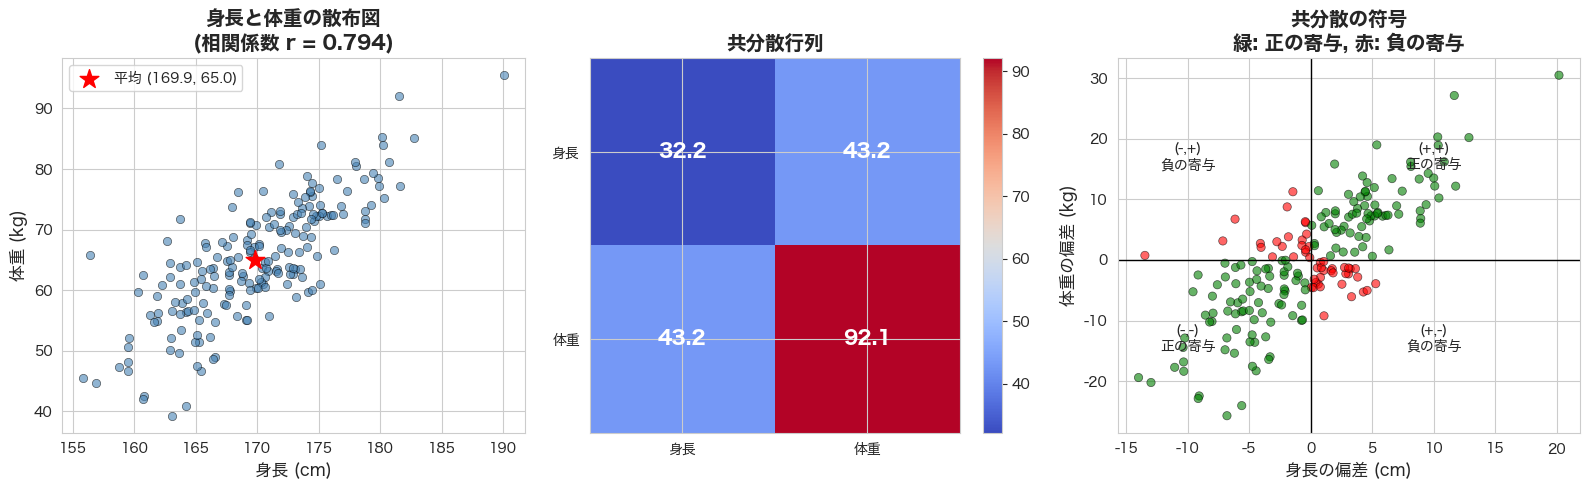


💡 ポイント: 共分散は (x-μ_x)(y-μ_y) の平均です
   正の相関があるとき、多くの点が緑（第1,3象限）に集中します


In [4]:
# ============================================================
# 共分散の計算と可視化
# 身長と体重のデータで共分散を理解します
# ============================================================

np.random.seed(42)

# 相関のあるデータを生成（身長と体重）
n = 200

# 平均と共分散行列を設定
mean = [170, 65]  # 平均身長170cm, 平均体重65kg
# 共分散行列: 身長の分散=36(σ=6), 体重の分散=100(σ=10), 共分散=48(正の相関)
cov = [[36, 48], 
       [48, 100]]

# 2次元正規分布からサンプリング
data = np.random.multivariate_normal(mean, cov, n)
heights = data[:, 0]
weights = data[:, 1]

# 共分散を計算
cov_computed = np.cov(heights, weights, ddof=0)

print("="*60)
print("共分散の計算")
print("="*60)
print(f"\nサンプル数: {n}")
print(f"\n設定した共分散行列:")
print(np.array(cov))
print(f"\n計算した共分散行列:")
print(cov_computed.round(2))

# 相関係数
correlation = np.corrcoef(heights, weights)[0, 1]
print(f"\n相関係数: {correlation:.4f}")

# 可視化
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 左: 散布図
axes[0].scatter(heights, weights, alpha=0.6, c='steelblue', edgecolors='black', linewidth=0.5)
axes[0].scatter(np.mean(heights), np.mean(weights), color='red', s=200, marker='*', 
                zorder=5, label=f'平均 ({np.mean(heights):.1f}, {np.mean(weights):.1f})')
axes[0].set_xlabel('身長 (cm)', fontsize=12)
axes[0].set_ylabel('体重 (kg)', fontsize=12)
axes[0].set_title(f'身長と体重の散布図\n(相関係数 r = {correlation:.3f})', fontsize=14, fontweight='bold')
axes[0].legend()

# 中央: 共分散行列のヒートマップ
im = axes[1].imshow(cov_computed, cmap='coolwarm', aspect='auto')
axes[1].set_xticks([0, 1])
axes[1].set_yticks([0, 1])
axes[1].set_xticklabels(['身長', '体重'])
axes[1].set_yticklabels(['身長', '体重'])
axes[1].set_title('共分散行列', fontsize=14, fontweight='bold')

# 値を表示
for i in range(2):
    for j in range(2):
        axes[1].text(j, i, f'{cov_computed[i, j]:.1f}', ha='center', va='center', 
                     fontsize=14, fontweight='bold', color='white')
plt.colorbar(im, ax=axes[1])

# 右: 共分散の意味を図解
# 平均からの偏差を計算
h_centered = heights - np.mean(heights)
w_centered = weights - np.mean(weights)

# 4つの象限で色分け
colors = []
for h, w in zip(h_centered, w_centered):
    if h > 0 and w > 0:  # 第1象限（++）
        colors.append('green')
    elif h < 0 and w < 0:  # 第3象限（--）
        colors.append('green')  # 積は正
    else:  # 第2, 4象限
        colors.append('red')  # 積は負

axes[2].scatter(h_centered, w_centered, c=colors, alpha=0.6, edgecolors='black', linewidth=0.5)
axes[2].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[2].axvline(x=0, color='black', linestyle='-', linewidth=1)
axes[2].set_xlabel('身長の偏差 (cm)', fontsize=12)
axes[2].set_ylabel('体重の偏差 (kg)', fontsize=12)
axes[2].set_title('共分散の符号\n緑: 正の寄与, 赤: 負の寄与', fontsize=14, fontweight='bold')

# 象限のラベル
axes[2].text(10, 15, '(+,+)\n正の寄与', fontsize=10, ha='center')
axes[2].text(-10, -15, '(-,-)\n正の寄与', fontsize=10, ha='center')
axes[2].text(10, -15, '(+,-)\n負の寄与', fontsize=10, ha='center')
axes[2].text(-10, 15, '(-,+)\n負の寄与', fontsize=10, ha='center')

plt.tight_layout()
plt.show()

print("\n💡 ポイント: 共分散は (x-μ_x)(y-μ_y) の平均です")
print("   正の相関があるとき、多くの点が緑（第1,3象限）に集中します")

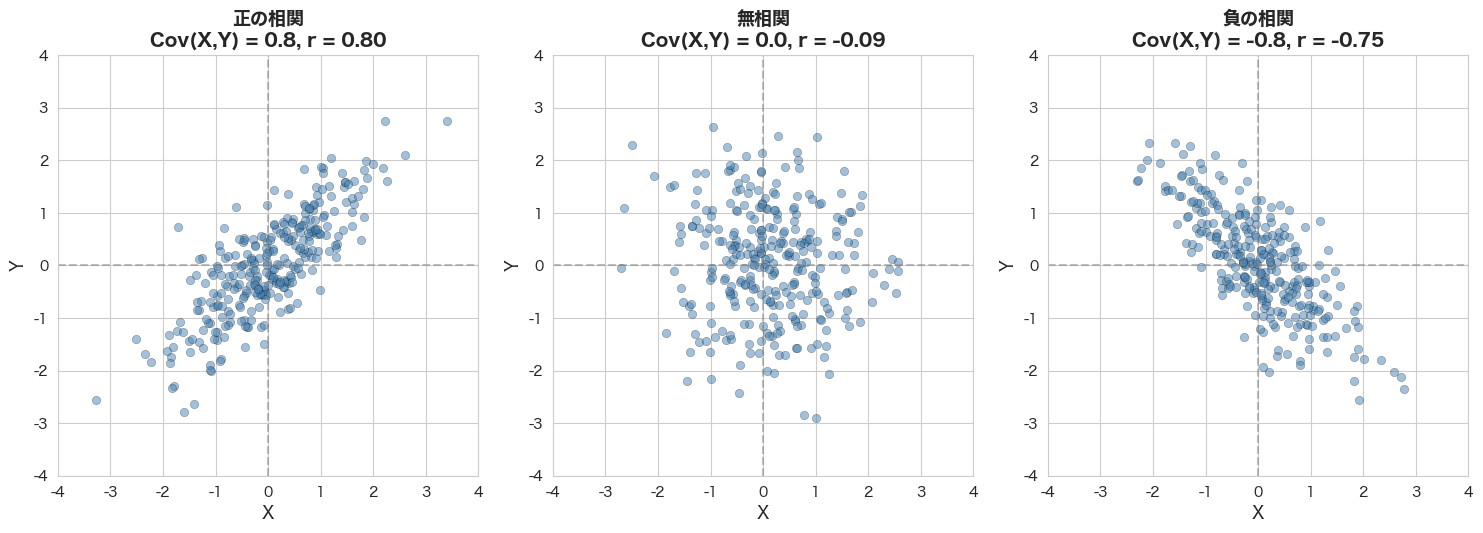

In [5]:
# ============================================================
# 様々な共分散パターン
# 正の相関、負の相関、無相関のデータを比較します
# ============================================================

np.random.seed(42)
n = 300

# 3つのパターンの共分散行列
patterns = [
    ('正の相関', [[1, 0.8], [0.8, 1]]),
    ('無相関', [[1, 0], [0, 1]]),
    ('負の相関', [[1, -0.8], [-0.8, 1]]),
]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, (title, cov) in zip(axes, patterns):
    # データ生成
    data = np.random.multivariate_normal([0, 0], cov, n)
    
    # 散布図
    ax.scatter(data[:, 0], data[:, 1], alpha=0.5, c='steelblue', edgecolors='black', linewidth=0.3)
    
    # 相関係数
    r = np.corrcoef(data[:, 0], data[:, 1])[0, 1]
    
    ax.set_xlabel('X', fontsize=12)
    ax.set_ylabel('Y', fontsize=12)
    ax.set_title(f'{title}\nCov(X,Y) = {cov[0][1]:.1f}, r = {r:.2f}', fontsize=13, fontweight='bold')
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)
    ax.set_aspect('equal')
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    ax.axvline(x=0, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

---

## 3. 多次元正規分布

### 📊 確率密度関数

$d$ 次元の正規分布 $\mathcal{N}(\boldsymbol{\mu}, \Sigma)$ の確率密度関数は：

$$p(\mathbf{x}) = \frac{1}{(2\pi)^{d/2} |\Sigma|^{1/2}} \exp\left(-\frac{1}{2}(\mathbf{x} - \boldsymbol{\mu})^T \Sigma^{-1} (\mathbf{x} - \boldsymbol{\mu})\right)$$

ここで：
- $\mathbf{x}$: $d$ 次元ベクトル
- $\boldsymbol{\mu}$: 平均ベクトル（$d$ 次元）
- $\Sigma$: 共分散行列（$d \times d$）
- $|\Sigma|$: 共分散行列の行列式
- $\Sigma^{-1}$: 共分散行列の逆行列

### 📊 1次元との比較

| 1次元 | 多次元 |
|-------|--------|
| $x$ | $\mathbf{x}$ （ベクトル）|
| $\mu$ | $\boldsymbol{\mu}$ （ベクトル）|
| $\sigma^2$ | $\Sigma$ （行列）|
| $\frac{1}{\sqrt{2\pi\sigma^2}}$ | $\frac{1}{(2\pi)^{d/2}\|\Sigma\|^{1/2}}$ |
| $\frac{(x-\mu)^2}{\sigma^2}$ | $(\mathbf{x}-\boldsymbol{\mu})^T\Sigma^{-1}(\mathbf{x}-\boldsymbol{\mu})$ |

In [6]:
# ============================================================
# 多次元正規分布の実装
# 2次元正規分布を例に、確率密度関数を実装します
# ============================================================

def multivariate_normal_pdf(x, mu, sigma):
    """
    多次元正規分布の確率密度関数
    
    Parameters:
    -----------
    x : array-like
        評価点（d次元ベクトル）
    mu : array-like
        平均ベクトル（d次元）
    sigma : array-like
        共分散行列（d×d）
    
    Returns:
    --------
    float
        確率密度
    """
    x = np.array(x)
    mu = np.array(mu)
    sigma = np.array(sigma)
    
    d = len(mu)  # 次元数
    
    # 正規化定数
    det_sigma = np.linalg.det(sigma)  # 行列式
    normalization = 1 / ((2 * np.pi) ** (d/2) * np.sqrt(det_sigma))
    
    # マハラノビス距離の2乗
    sigma_inv = np.linalg.inv(sigma)  # 逆行列
    diff = x - mu
    mahalanobis_sq = diff @ sigma_inv @ diff
    
    # 確率密度
    pdf = normalization * np.exp(-0.5 * mahalanobis_sq)
    
    return pdf

# テスト
mu = np.array([0, 0])
sigma = np.array([[1, 0.5], [0.5, 1]])

# いくつかの点で確率密度を計算
test_points = [
    [0, 0],      # 平均
    [1, 1],      # 平均から離れた点
    [-1, 1],     # 別の点
]

print("="*60)
print("多次元正規分布の確率密度")
print("="*60)
print(f"\n平均: μ = {mu}")
print(f"共分散行列: Σ = \n{sigma}")

print(f"\n各点での確率密度:")
for x in test_points:
    pdf_custom = multivariate_normal_pdf(x, mu, sigma)
    pdf_scipy = stats.multivariate_normal.pdf(x, mu, sigma)
    print(f"  x = {x}: p(x) = {pdf_custom:.6f} (scipy: {pdf_scipy:.6f})")

多次元正規分布の確率密度

平均: μ = [0 0]
共分散行列: Σ = 
[[1.  0.5]
 [0.5 1. ]]

各点での確率密度:
  x = [0, 0]: p(x) = 0.183776 (scipy: 0.183776)
  x = [1, 1]: p(x) = 0.094354 (scipy: 0.094354)
  x = [-1, 1]: p(x) = 0.024871 (scipy: 0.024871)


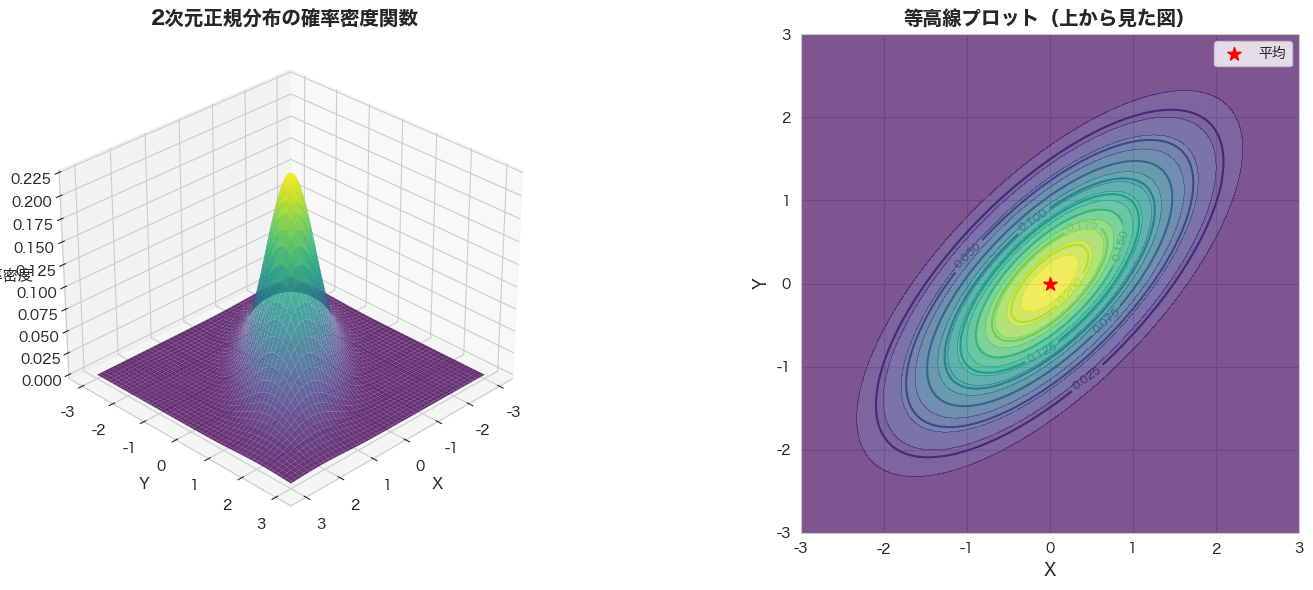

💡 等高線は楕円形になります。共分散行列が楕円の向きと形状を決めます


In [7]:
# ============================================================
# 2次元正規分布の3D可視化
# 確率密度関数を3Dプロットで表示します
# ============================================================

# パラメータ
mu = np.array([0, 0])
sigma = np.array([[1, 0.7], [0.7, 1]])

# グリッドを作成
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
X, Y = np.meshgrid(x, y)

# 各点で確率密度を計算
pos = np.dstack((X, Y))
rv = stats.multivariate_normal(mu, sigma)
Z = rv.pdf(pos)

fig = plt.figure(figsize=(16, 6))

# 左: 3Dプロット
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8, edgecolor='none')
ax1.set_xlabel('X', fontsize=11)
ax1.set_ylabel('Y', fontsize=11)
ax1.set_zlabel('確率密度', fontsize=11)
ax1.set_title('2次元正規分布の確率密度関数', fontsize=14, fontweight='bold')
ax1.view_init(elev=30, azim=45)

# 右: 等高線プロット
ax2 = fig.add_subplot(122)
contour = ax2.contour(X, Y, Z, levels=10, cmap='viridis')
ax2.clabel(contour, inline=True, fontsize=8)
ax2.contourf(X, Y, Z, levels=20, cmap='viridis', alpha=0.7)

# 平均点をマーク
ax2.scatter([mu[0]], [mu[1]], color='red', s=100, marker='*', zorder=5, label='平均')

ax2.set_xlabel('X', fontsize=12)
ax2.set_ylabel('Y', fontsize=12)
ax2.set_title('等高線プロット（上から見た図）', fontsize=14, fontweight='bold')
ax2.set_aspect('equal')
ax2.legend()

plt.tight_layout()
plt.show()

print("💡 等高線は楕円形になります。共分散行列が楕円の向きと形状を決めます")

---

## 4. 共分散行列と分布の形状

### 🤔 共分散行列が決めるもの

共分散行列 $\Sigma$ は、多次元正規分布の「形状」を決定します：

1. **対角成分**: 各軸方向のばらつき（分散）
2. **非対角成分**: 軸間の相関（楕円の傾き）

共分散行列の固有値と固有ベクトルが、楕円の主軸の長さと方向を決めます。

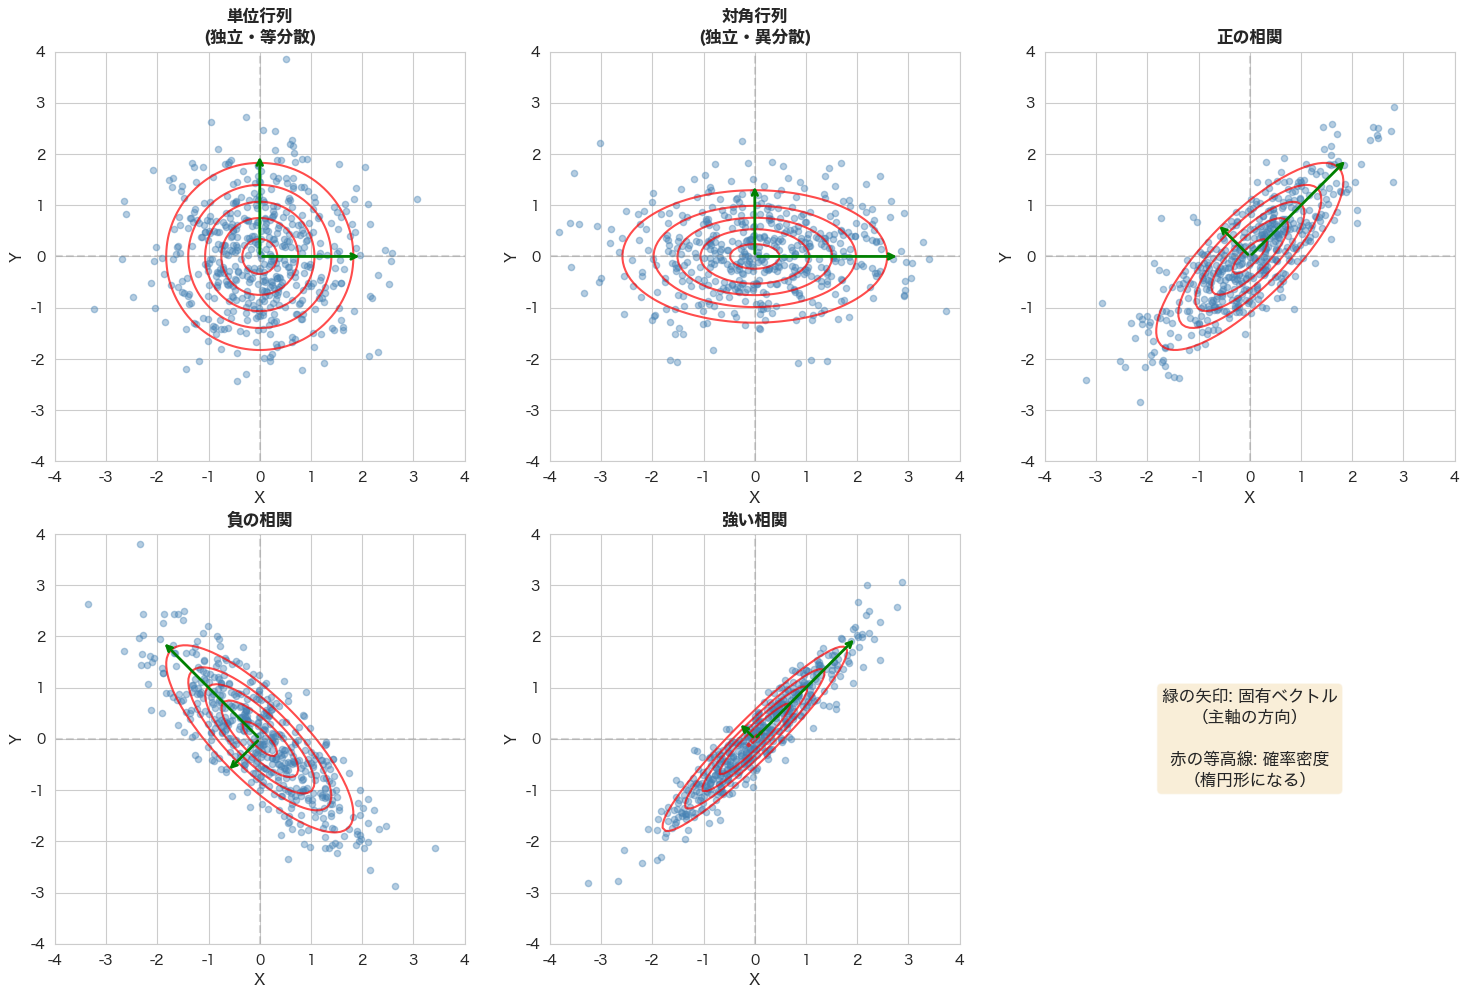

In [8]:
# ============================================================
# 共分散行列と分布形状の関係
# 異なる共分散行列での分布を比較します
# ============================================================

np.random.seed(42)

# 5つの異なる共分散行列
covariances = [
    ("単位行列\n(独立・等分散)", [[1, 0], [0, 1]]),
    ("対角行列\n(独立・異分散)", [[2, 0], [0, 0.5]]),
    ("正の相関", [[1, 0.8], [0.8, 1]]),
    ("負の相関", [[1, -0.8], [-0.8, 1]]),
    ("強い相関", [[1, 0.95], [0.95, 1]]),
]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

mu = [0, 0]
n_samples = 500

for idx, (title, cov) in enumerate(covariances):
    ax = axes[idx]
    cov = np.array(cov)
    
    # サンプル生成
    samples = np.random.multivariate_normal(mu, cov, n_samples)
    
    # 散布図
    ax.scatter(samples[:, 0], samples[:, 1], alpha=0.4, s=20, c='steelblue')
    
    # 等高線を追加
    x = np.linspace(-4, 4, 100)
    y = np.linspace(-4, 4, 100)
    X, Y = np.meshgrid(x, y)
    pos = np.dstack((X, Y))
    rv = stats.multivariate_normal(mu, cov)
    Z = rv.pdf(pos)
    ax.contour(X, Y, Z, levels=5, colors='red', alpha=0.7)
    
    # 固有値分解で主軸を表示
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    for i in range(2):
        # 固有ベクトルの方向に線を引く
        v = eigenvectors[:, i] * np.sqrt(eigenvalues[i]) * 2  # 2σの長さ
        ax.annotate('', xy=v, xytext=[0, 0],
                    arrowprops=dict(arrowstyle='->', color='green', lw=2))
    
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)
    ax.set_aspect('equal')
    ax.set_xlabel('X', fontsize=11)
    ax.set_ylabel('Y', fontsize=11)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
    ax.axvline(x=0, color='gray', linestyle='--', alpha=0.3)

# 最後のサブプロットは使わない
axes[5].axis('off')
axes[5].text(0.5, 0.5, '緑の矢印: 固有ベクトル\n（主軸の方向）\n\n赤の等高線: 確率密度\n（楕円形になる）', 
             ha='center', va='center', fontsize=12, transform=axes[5].transAxes,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

共分散行列の固有値分解

共分散行列 Σ = 
[[2.  1.5]
 [1.5 2. ]]

固有値: λ = [0.5 3.5]
  → 楕円の各軸方向の分散を表す
  → 標準偏差: σ = [0.70710678 1.87082869]

固有ベクトル:
  v1 = [-0.70710678  0.70710678]  (λ = 0.50)
  v2 = [0.70710678 0.70710678]  (λ = 3.50)
  → 楕円の主軸の方向を表す


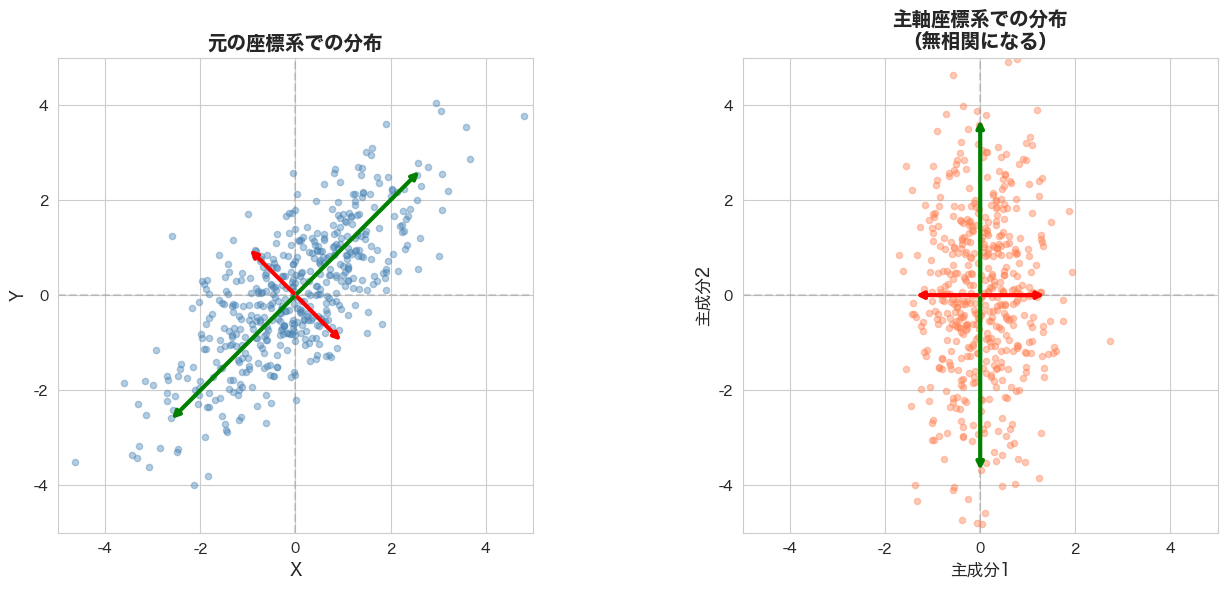


変換後の共分散行列:
[[0.492 0.033]
 [0.033 3.273]]
→ 対角行列に近い（無相関化された）


In [9]:
# ============================================================
# 固有値分解と楕円の関係
# 共分散行列の固有値・固有ベクトルの意味を解説します
# ============================================================

# 例として相関のある共分散行列を使用
sigma = np.array([[2, 1.5], [1.5, 2]])

# 固有値分解
eigenvalues, eigenvectors = np.linalg.eigh(sigma)

print("="*60)
print("共分散行列の固有値分解")
print("="*60)
print(f"\n共分散行列 Σ = \n{sigma}")
print(f"\n固有値: λ = {eigenvalues}")
print(f"  → 楕円の各軸方向の分散を表す")
print(f"  → 標準偏差: σ = {np.sqrt(eigenvalues)}")
print(f"\n固有ベクトル:")
for i in range(2):
    print(f"  v{i+1} = {eigenvectors[:, i]}  (λ = {eigenvalues[i]:.2f})")
print(f"  → 楕円の主軸の方向を表す")

# 可視化
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# サンプル生成
np.random.seed(42)
samples = np.random.multivariate_normal([0, 0], sigma, 500)

# 左: 元の座標系
ax = axes[0]
ax.scatter(samples[:, 0], samples[:, 1], alpha=0.4, s=20, c='steelblue')

# 固有ベクトルを矢印で表示
colors = ['red', 'green']
for i in range(2):
    v = eigenvectors[:, i] * np.sqrt(eigenvalues[i]) * 2
    ax.annotate('', xy=v, xytext=[0, 0],
                arrowprops=dict(arrowstyle='->', color=colors[i], lw=3))
    ax.annotate('', xy=-v, xytext=[0, 0],
                arrowprops=dict(arrowstyle='->', color=colors[i], lw=3))

ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.set_aspect('equal')
ax.set_xlabel('X', fontsize=12)
ax.set_ylabel('Y', fontsize=12)
ax.set_title('元の座標系での分布', fontsize=14, fontweight='bold')
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
ax.axvline(x=0, color='gray', linestyle='--', alpha=0.3)

# 右: 主軸座標系に変換
ax = axes[1]
# 固有ベクトルで座標変換
samples_transformed = samples @ eigenvectors

ax.scatter(samples_transformed[:, 0], samples_transformed[:, 1], alpha=0.4, s=20, c='coral')

# 変換後は軸に沿った楕円になる
for i in range(2):
    length = np.sqrt(eigenvalues[i]) * 2
    if i == 0:
        ax.annotate('', xy=[length, 0], xytext=[0, 0],
                    arrowprops=dict(arrowstyle='->', color='red', lw=3))
        ax.annotate('', xy=[-length, 0], xytext=[0, 0],
                    arrowprops=dict(arrowstyle='->', color='red', lw=3))
    else:
        ax.annotate('', xy=[0, length], xytext=[0, 0],
                    arrowprops=dict(arrowstyle='->', color='green', lw=3))
        ax.annotate('', xy=[0, -length], xytext=[0, 0],
                    arrowprops=dict(arrowstyle='->', color='green', lw=3))

ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.set_aspect('equal')
ax.set_xlabel('主成分1', fontsize=12)
ax.set_ylabel('主成分2', fontsize=12)
ax.set_title('主軸座標系での分布\n（無相関になる）', fontsize=14, fontweight='bold')
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
ax.axvline(x=0, color='gray', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

# 変換後の共分散行列を確認
cov_transformed = np.cov(samples_transformed.T)
print(f"\n変換後の共分散行列:")
print(cov_transformed.round(3))
print("→ 対角行列に近い（無相関化された）")

---

## 5. 多次元正規分布からのサンプリング

### 📊 サンプリングの方法

多次元正規分布からサンプリングするには、NumPyの `np.random.multivariate_normal()` を使います。

内部的には以下の手順で行われます：

1. 標準正規分布 $\mathcal{N}(0, I)$ からサンプル $\mathbf{z}$ を生成
2. コレスキー分解 $\Sigma = LL^T$ を計算
3. $\mathbf{x} = \boldsymbol{\mu} + L\mathbf{z}$ で変換

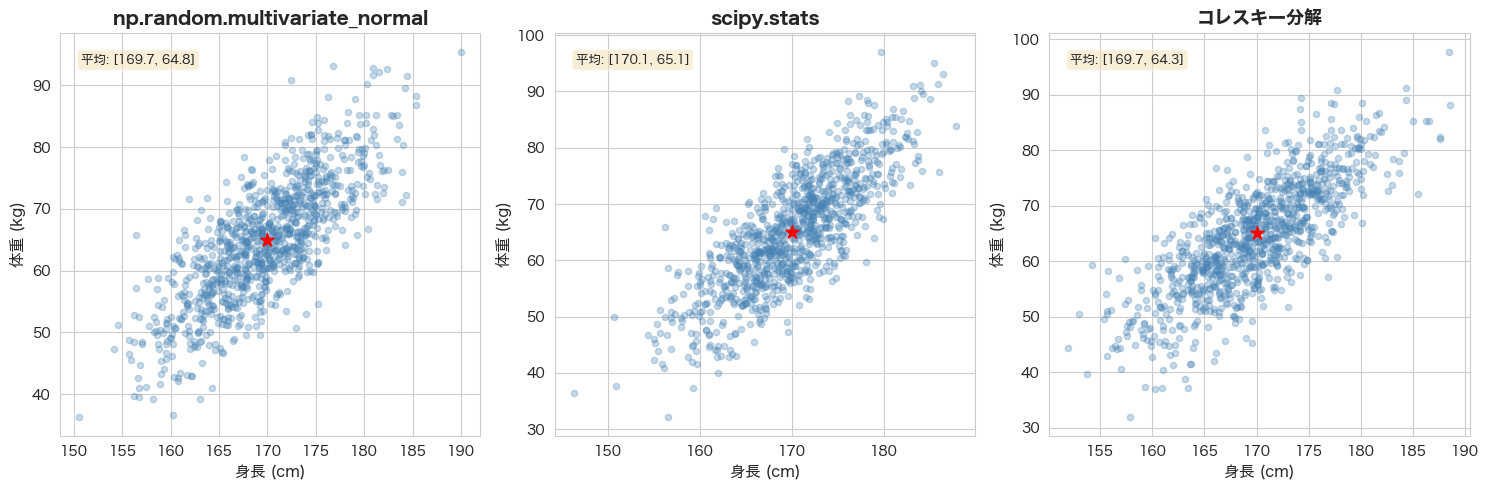

サンプリング結果の比較

設定パラメータ:
  平均: [170  65]
  共分散行列:
[[ 36  48]
 [ 48 100]]

各方法のサンプル統計量（平均）:
  NumPy: [169.66  64.76]
  SciPy: [170.06  65.1 ]
  Manual: [169.74  64.34]


In [10]:
# ============================================================
# 多次元正規分布からのサンプリング
# NumPyとscipyの両方を使う方法を示します
# ============================================================

np.random.seed(42)

# パラメータ
mu = np.array([170, 65])  # 身長(cm), 体重(kg)
sigma = np.array([[36, 48], [48, 100]])  # 共分散行列

# 方法1: np.random.multivariate_normal
samples_numpy = np.random.multivariate_normal(mu, sigma, 1000)

# 方法2: scipy.stats.multivariate_normal
rv = stats.multivariate_normal(mu, sigma)
samples_scipy = rv.rvs(1000)

# 方法3: コレスキー分解を使った手動実装
def sample_multivariate_normal(mu, sigma, n):
    """
    コレスキー分解を使って多次元正規分布からサンプリング
    
    手順:
    1. 標準正規分布から d 次元ベクトル z をサンプリング
    2. Σ = L @ L.T となる下三角行列 L を計算（コレスキー分解）
    3. x = μ + L @ z で変換
    """
    d = len(mu)
    # コレスキー分解
    L = np.linalg.cholesky(sigma)
    
    # 標準正規分布からサンプリング
    z = np.random.standard_normal((n, d))
    
    # 変換: x = μ + L @ z
    samples = mu + z @ L.T
    
    return samples

samples_manual = sample_multivariate_normal(mu, sigma, 1000)

# 可視化
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, samples, title in zip(axes, 
                               [samples_numpy, samples_scipy, samples_manual],
                               ['np.random.multivariate_normal', 'scipy.stats', 'コレスキー分解']):
    ax.scatter(samples[:, 0], samples[:, 1], alpha=0.3, s=20, c='steelblue')
    ax.scatter(mu[0], mu[1], color='red', s=100, marker='*', zorder=5)
    ax.set_xlabel('身長 (cm)', fontsize=11)
    ax.set_ylabel('体重 (kg)', fontsize=11)
    ax.set_title(title, fontsize=13, fontweight='bold')
    
    # 統計量を表示
    sample_mean = np.mean(samples, axis=0)
    sample_cov = np.cov(samples.T)
    ax.text(0.05, 0.95, f'平均: [{sample_mean[0]:.1f}, {sample_mean[1]:.1f}]',
            transform=ax.transAxes, fontsize=9, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print("="*60)
print("サンプリング結果の比較")
print("="*60)
print(f"\n設定パラメータ:")
print(f"  平均: {mu}")
print(f"  共分散行列:\n{sigma}")
print(f"\n各方法のサンプル統計量（平均）:")
for samples, name in zip([samples_numpy, samples_scipy, samples_manual],
                         ['NumPy', 'SciPy', 'Manual']):
    print(f"  {name}: {np.mean(samples, axis=0).round(2)}")

---

## 6. 多次元正規分布の最尤推定

### 📊 パラメータの推定式

データ $\mathbf{x}_1, \mathbf{x}_2, ..., \mathbf{x}_n$ が与えられたとき、多次元正規分布のMLEは：

**平均ベクトル:**
$$\hat{\boldsymbol{\mu}} = \frac{1}{n}\sum_{i=1}^n \mathbf{x}_i$$

**共分散行列:**
$$\hat{\Sigma} = \frac{1}{n}\sum_{i=1}^n (\mathbf{x}_i - \hat{\boldsymbol{\mu}})(\mathbf{x}_i - \hat{\boldsymbol{\mu}})^T$$

1次元の場合と同様、サンプル平均とサンプル共分散がMLEになります。

In [11]:
# ============================================================
# 多次元正規分布の最尤推定
# 身長・体重データからパラメータを推定します
# ============================================================

np.random.seed(42)

# 真のパラメータ
true_mu = np.array([170, 65])
true_sigma = np.array([[36, 48], [48, 100]])

# データを生成
n_samples = 200
data = np.random.multivariate_normal(true_mu, true_sigma, n_samples)

# 最尤推定
# 平均ベクトル
mu_mle = np.mean(data, axis=0)

# 共分散行列（ddof=0 でMLE）
sigma_mle = np.cov(data.T, ddof=0)

print("="*60)
print("多次元正規分布の最尤推定")
print("="*60)
print(f"\nサンプル数: {n_samples}")

print(f"\n【真のパラメータ】")
print(f"  μ = {true_mu}")
print(f"  Σ = \n{true_sigma}")

print(f"\n【最尤推定値】")
print(f"  μ̂ = {mu_mle.round(2)}")
print(f"  Σ̂ = \n{sigma_mle.round(2)}")

# 推定誤差
print(f"\n【推定誤差】")
print(f"  |μ̂ - μ| = {np.linalg.norm(mu_mle - true_mu):.4f}")
print(f"  |Σ̂ - Σ|_F = {np.linalg.norm(sigma_mle - true_sigma, 'fro'):.4f}")

多次元正規分布の最尤推定

サンプル数: 200

【真のパラメータ】
  μ = [170  65]
  Σ = 
[[ 36  48]
 [ 48 100]]

【最尤推定値】
  μ̂ = [169.86  65.  ]
  Σ̂ = 
[[32.19 43.24]
 [43.24 92.09]]

【推定誤差】
  |μ̂ - μ| = 0.1433
  |Σ̂ - Σ|_F = 11.0662


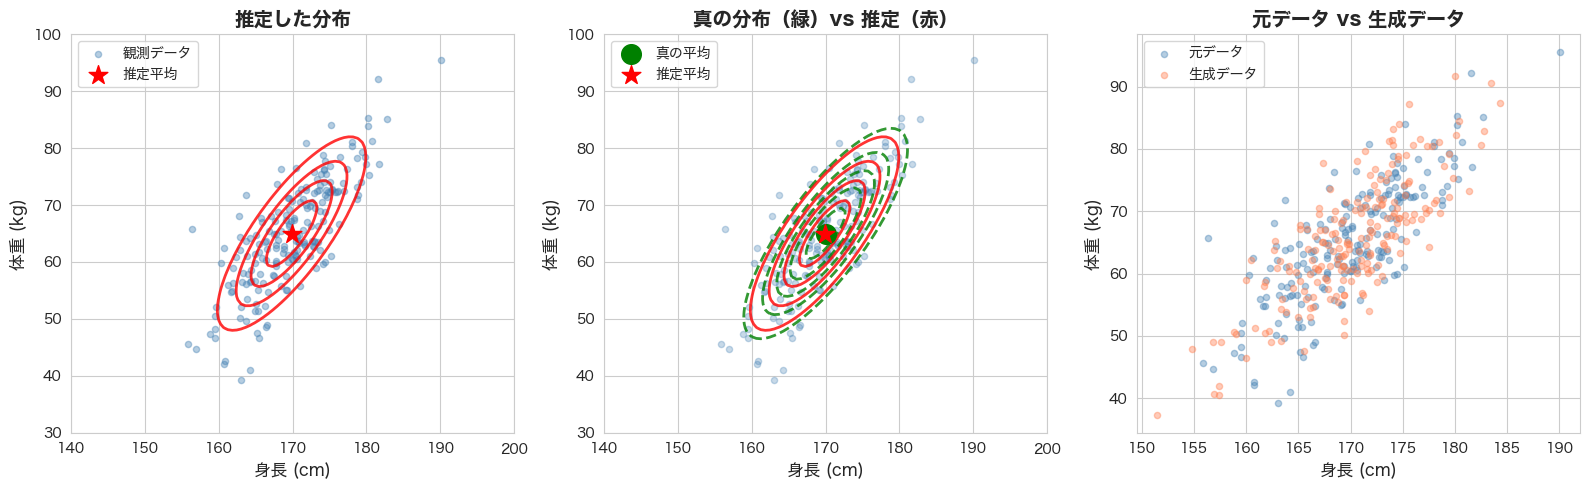

💡 推定した分布から生成したデータは、元のデータと似た分布になります


In [12]:
# ============================================================
# 推定結果の可視化
# 真の分布と推定した分布を比較します
# ============================================================

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 左: データと推定した分布
ax = axes[0]
ax.scatter(data[:, 0], data[:, 1], alpha=0.4, s=20, c='steelblue', label='観測データ')

# 等高線（推定した分布）
x = np.linspace(140, 200, 100)
y = np.linspace(30, 100, 100)
X, Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))

rv_estimated = stats.multivariate_normal(mu_mle, sigma_mle)
Z_estimated = rv_estimated.pdf(pos)
ax.contour(X, Y, Z_estimated, levels=5, colors='red', alpha=0.8, linewidths=2)

ax.scatter(mu_mle[0], mu_mle[1], color='red', s=200, marker='*', zorder=5, label='推定平均')
ax.set_xlabel('身長 (cm)', fontsize=12)
ax.set_ylabel('体重 (kg)', fontsize=12)
ax.set_title('推定した分布', fontsize=14, fontweight='bold')
ax.legend()

# 中央: 真の分布との比較
ax = axes[1]
ax.scatter(data[:, 0], data[:, 1], alpha=0.3, s=20, c='steelblue')

rv_true = stats.multivariate_normal(true_mu, true_sigma)
Z_true = rv_true.pdf(pos)

ax.contour(X, Y, Z_true, levels=5, colors='green', alpha=0.8, linewidths=2, linestyles='--')
ax.contour(X, Y, Z_estimated, levels=5, colors='red', alpha=0.8, linewidths=2)

ax.scatter(true_mu[0], true_mu[1], color='green', s=200, marker='o', zorder=5, label='真の平均')
ax.scatter(mu_mle[0], mu_mle[1], color='red', s=200, marker='*', zorder=5, label='推定平均')
ax.set_xlabel('身長 (cm)', fontsize=12)
ax.set_ylabel('体重 (kg)', fontsize=12)
ax.set_title('真の分布（緑）vs 推定（赤）', fontsize=14, fontweight='bold')
ax.legend()

# 右: 生成データの比較
ax = axes[2]

# 推定した分布から新しいデータを生成
generated = np.random.multivariate_normal(mu_mle, sigma_mle, 200)

ax.scatter(data[:, 0], data[:, 1], alpha=0.4, s=20, c='steelblue', label='元データ')
ax.scatter(generated[:, 0], generated[:, 1], alpha=0.4, s=20, c='coral', label='生成データ')
ax.set_xlabel('身長 (cm)', fontsize=12)
ax.set_ylabel('体重 (kg)', fontsize=12)
ax.set_title('元データ vs 生成データ', fontsize=14, fontweight='bold')
ax.legend()

plt.tight_layout()
plt.show()

print("💡 推定した分布から生成したデータは、元のデータと似た分布になります")

---

## 7. 実践: 多次元生成モデル

### 📊 多次元正規分布による生成モデル

最尤推定で学習した多次元正規分布を使って、生成モデルを実装します。

モデルを学習しました（3次元）
  平均: [169.77  64.08  89.88]


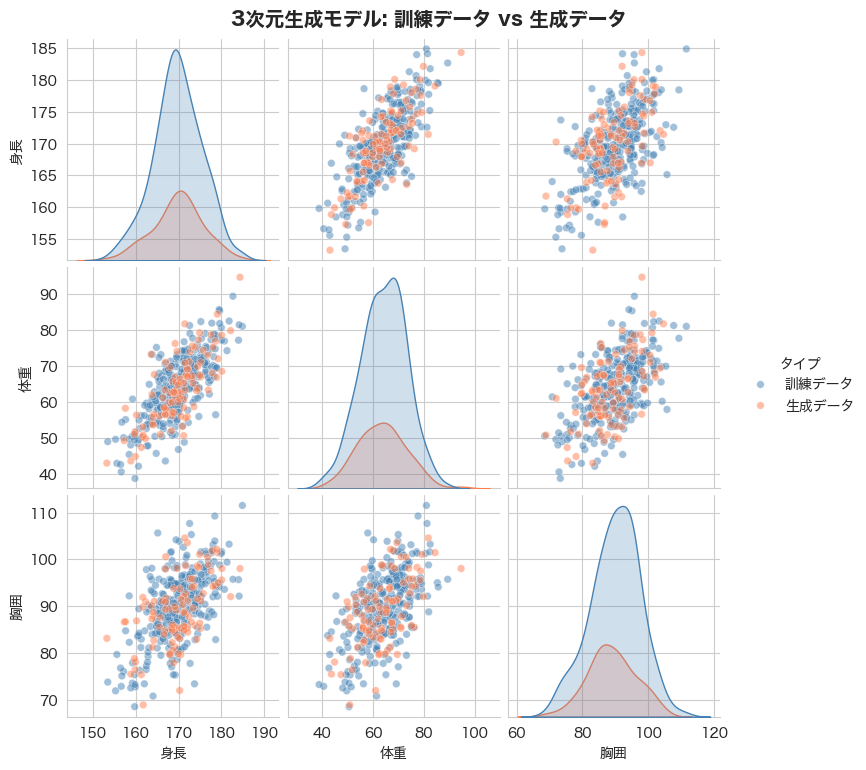


統計量の比較

【平均】
  訓練: [169.77  64.08  89.88]
  生成: [169.82  63.54  88.93]

【標準偏差】
  訓練: [5.64 8.92 7.55]
  生成: [5.8  9.44 7.2 ]


In [13]:
# ============================================================
# 多次元正規分布による生成モデル
# 身長・体重・胸囲の3次元データを扱います
# ============================================================

np.random.seed(42)

class MultivariateNormalGenerator:
    """
    多次元正規分布による生成モデル
    """
    
    def __init__(self):
        self.mu = None
        self.sigma = None
        self.d = None  # 次元数
        self.is_fitted = False
    
    def fit(self, X):
        """
        データから最尤推定でパラメータを学習
        
        Parameters:
        -----------
        X : array-like, shape (n_samples, n_features)
            訓練データ
        """
        X = np.array(X)
        self.d = X.shape[1]
        
        # 平均ベクトル
        self.mu = np.mean(X, axis=0)
        
        # 共分散行列
        self.sigma = np.cov(X.T, ddof=0)
        
        self.is_fitted = True
        print(f"モデルを学習しました（{self.d}次元）")
        print(f"  平均: {self.mu.round(2)}")
        return self
    
    def generate(self, n_samples):
        """
        新しいデータを生成
        """
        if not self.is_fitted:
            raise ValueError("モデルが学習されていません")
        return np.random.multivariate_normal(self.mu, self.sigma, n_samples)
    
    def log_likelihood(self, X):
        """
        データの対数尤度を計算
        """
        if not self.is_fitted:
            raise ValueError("モデルが学習されていません")
        rv = stats.multivariate_normal(self.mu, self.sigma)
        return np.sum(rv.logpdf(X))

# 3次元のデータを作成（身長、体重、胸囲）
true_mu = np.array([170, 65, 90])  # 平均
true_sigma = np.array([
    [36, 48, 30],    # 身長の分散と共分散
    [48, 100, 50],   # 体重の分散と共分散
    [30, 50, 64],    # 胸囲の分散と共分散
])

# 訓練データ
n_train = 300
train_data = np.random.multivariate_normal(true_mu, true_sigma, n_train)

# モデルを学習
model = MultivariateNormalGenerator()
model.fit(train_data)

# 新しいデータを生成
generated_data = model.generate(100)

# 可視化（3次元データなので、ペアプロットで表示）
import pandas as pd

# DataFrameに変換
df_train = pd.DataFrame(train_data, columns=['身長', '体重', '胸囲'])
df_train['タイプ'] = '訓練データ'

df_generated = pd.DataFrame(generated_data, columns=['身長', '体重', '胸囲'])
df_generated['タイプ'] = '生成データ'

df_combined = pd.concat([df_train, df_generated], ignore_index=True)

# ペアプロット
g = sns.pairplot(df_combined, hue='タイプ', diag_kind='kde', 
                  plot_kws={'alpha': 0.5, 's': 30},
                  palette={'訓練データ': 'steelblue', '生成データ': 'coral'})
g.fig.suptitle('3次元生成モデル: 訓練データ vs 生成データ', y=1.02, fontsize=14, fontweight='bold')
plt.show()

# 統計量の比較
print("\n" + "="*60)
print("統計量の比較")
print("="*60)
print(f"\n【平均】")
print(f"  訓練: {np.mean(train_data, axis=0).round(2)}")
print(f"  生成: {np.mean(generated_data, axis=0).round(2)}")
print(f"\n【標準偏差】")
print(f"  訓練: {np.std(train_data, axis=0).round(2)}")
print(f"  生成: {np.std(generated_data, axis=0).round(2)}")

---

## まとめ

### 🎯 このノートブックで学んだこと

**ベクトルと行列**
- ✓ 多次元データはベクトル、複数データは行列で表現
- ✓ 転置、行列積、逆行列、行列式などの基本演算

**共分散と共分散行列**
- ✓ 共分散は2変数の連動の強さを表す
- ✓ 共分散行列は対角成分が分散、非対角成分が共分散
- ✓ 固有値分解で楕円の主軸が分かる

**多次元正規分布**
- ✓ 確率密度関数: $p(\mathbf{x}) = \frac{1}{(2\pi)^{d/2}|\Sigma|^{1/2}}\exp(-\frac{1}{2}(\mathbf{x}-\boldsymbol{\mu})^T\Sigma^{-1}(\mathbf{x}-\boldsymbol{\mu}))$
- ✓ パラメータは平均ベクトル $\boldsymbol{\mu}$ と共分散行列 $\Sigma$
- ✓ 等確率面は楕円体

**最尤推定**
- ✓ $\hat{\boldsymbol{\mu}} = \bar{\mathbf{x}}$ （サンプル平均）
- ✓ $\hat{\Sigma} = \frac{1}{n}\sum(\mathbf{x}_i - \bar{\mathbf{x}})(\mathbf{x}_i - \bar{\mathbf{x}})^T$ （サンプル共分散）

### 📊 多次元正規分布のチートシート

| 項目 | 1次元 | 多次元 |
|------|-------|--------|
| 表記 | $\mathcal{N}(\mu, \sigma^2)$ | $\mathcal{N}(\boldsymbol{\mu}, \Sigma)$ |
| 平均 | スカラー $\mu$ | ベクトル $\boldsymbol{\mu}$ |
| 分散 | スカラー $\sigma^2$ | 行列 $\Sigma$ |
| 正規化 | $\frac{1}{\sqrt{2\pi\sigma^2}}$ | $\frac{1}{(2\pi)^{d/2}\|\Sigma\|^{1/2}}$ |
| 指数部 | $-\frac{(x-\mu)^2}{2\sigma^2}$ | $-\frac{1}{2}(\mathbf{x}-\boldsymbol{\mu})^T\Sigma^{-1}(\mathbf{x}-\boldsymbol{\mu})$ |

### 🔧 Pythonでの使い方

```python
import numpy as np
from scipy import stats

# パラメータ
mu = np.array([0, 0])
sigma = np.array([[1, 0.5], [0.5, 1]])

# サンプリング
samples = np.random.multivariate_normal(mu, sigma, n)

# 確率密度
rv = stats.multivariate_normal(mu, sigma)
pdf = rv.pdf(x)

# 最尤推定
mu_mle = np.mean(data, axis=0)
sigma_mle = np.cov(data.T, ddof=0)
```

---

### ⚠️ よくあるエラー

#### エラー #1: 共分散行列が正定値でない

```python
# ❌ 問題: 不正な共分散行列
sigma = [[1, 2], [2, 1]]  # 相関が1を超える → 正定値でない

# ✅ 正しい: 正定値であることを確認
sigma = [[1, 0.9], [0.9, 1]]  # |r| < 1 なのでOK

# 正定値かどうか確認する方法
eigenvalues = np.linalg.eigvalsh(sigma)
is_positive_definite = np.all(eigenvalues > 0)
```

#### エラー #2: 共分散行列の形状の間違い

```python
# ❌ 問題: np.cov の出力形状
data = np.random.randn(100, 2)  # 100サンプル × 2特徴量
cov = np.cov(data)  # 100×100 になってしまう！

# ✅ 正しい: 転置するか rowvar=False を指定
cov = np.cov(data.T)         # 2×2
cov = np.cov(data, rowvar=False)  # 2×2
```

---

## 🎓 自己評価クイズ

### Q1: 共分散 Cov(X, Y) = 0 は、XとYが独立であることを意味しますか？

<details>
<summary>💡 答えを見る</summary>

**答え**: いいえ、必ずしもそうではありません

共分散=0は「線形な関係がない」ことを意味しますが、非線形な関係がある可能性はあります。

例: X ∼ N(0,1) で Y = X² とすると、Cov(X, Y) = 0 ですが、XとYは明らかに従属です。

ただし、**正規分布の場合に限り**、無相関と独立は同値です。

</details>

---

### Q2: 共分散行列が対角行列の場合、変数間の関係はどうなりますか？

<details>
<summary>💡 答えを見る</summary>

**答え**: 変数間に相関がない（無相関）

対角行列は非対角成分がすべて0なので、変数間の共分散が0です。
多次元正規分布の場合、これは変数が独立であることを意味します。

等確率面は軸に平行な楕円（各軸方向に伸びた楕円）になります。

</details>

---

### Q3: 多次元正規分布の確率密度関数に現れる $(\mathbf{x}-\boldsymbol{\mu})^T\Sigma^{-1}(\mathbf{x}-\boldsymbol{\mu})$ は何を表しますか？

<details>
<summary>💡 答えを見る</summary>

**答え**: マハラノビス距離の2乗

これは、共分散構造を考慮した「平均からの距離」を表します。
ユークリッド距離と違い、変数間の相関を考慮します。

- 分散が大きい方向への偏差は「近い」と見なされる
- 相関がある場合は、その方向も考慮される

</details>

---

### Q4: なぜVAEや拡散モデルで多次元正規分布が使われるのですか？

<details>
<summary>💡 答えを見る</summary>

**答え**: 主に以下の理由があります

1. **再パラメータ化トリック**: 微分可能な形でサンプリングできる
   - $\mathbf{x} = \boldsymbol{\mu} + L\mathbf{z}$ （$\mathbf{z}$ ∼ N(0, I)）

2. **KLダイバージェンスの解析解**: 2つの正規分布間のKLダイバージェンスには閉形式の解がある

3. **中心極限定理**: 多くのステップのノイズを加えると正規分布に収束

4. **数学的な扱いやすさ**: 正規分布の和・積も正規分布になる

</details>

---

### Q5: 共分散行列の固有値がすべて正でなければならない理由は？

<details>
<summary>💡 答えを見る</summary>

**答え**: 共分散行列は正定値行列でなければならないから

正定値とは、任意の非ゼロベクトル $\mathbf{v}$ に対して $\mathbf{v}^T\Sigma\mathbf{v} > 0$ が成り立つこと。

理由:
1. 分散は常に非負: $\text{Var}(\mathbf{v}^T\mathbf{X}) = \mathbf{v}^T\Sigma\mathbf{v} \geq 0$
2. 確率密度関数が定義できる: 正定値でないと逆行列が存在しない
3. 行列式が正: 正規化定数の計算に必要

</details>

---

### 📚 練習問題

1. **3次元正規分布の可視化**: 3つの変数（身長、体重、年齢）を持つデータを生成し、ペアプロットで可視化してください。相関構造が正しく反映されているか確認しましょう。

2. **条件付き分布**: 2次元正規分布において、$X_1 = x_1$ が与えられたときの $X_2$ の条件付き分布を計算し、可視化してください。（ヒント: 条件付き分布も正規分布になります）

3. **異常検知**: 多次元正規分布を使った異常検知を実装してください。マハラノビス距離を使って、閾値を超えるデータを「異常」と判定しましょう。

---

### ✅ 学習チェックリスト

- [ ] 共分散と共分散行列の意味を説明できる
- [ ] 多次元正規分布の確率密度関数を書ける
- [ ] 共分散行列と分布の形状の関係を理解している
- [ ] Pythonで多次元正規分布からサンプリングできる
- [ ] 多次元データの最尤推定ができる

---

**次のステップ**: Notebook 33で、**混合ガウスモデル（GMM）**を学びます！

単一の正規分布では表現できない複雑なデータ分布を、複数の正規分布の混合でモデル化する方法を学習します。これはVAEの潜在変数モデルの理解にもつながります。